# AIML Engineer Take-Home Project


## Exercise Info and Requirements

### Objective
You are tasked with building a recommendation system using a provided public dataset,
focusing on both classical recommendation models and modern LLM-based approaches.


### Project Requirements
Package your application as a service using a suitable framework, e.g. FastAPI or Flask. We
are intentionally not being prescriptive here, but do your best to demonstrate your
understanding of best practices when building your solution.
1. Dataset
  - Use the [Anime Recommendations Database from Kaggle](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database). This dataset contains
information on various anime, including user ratings, genres, and other relevant
attributes.
2. Data Endpoint
  - Your service should have an API endpoint to query the dataset
3. Classical Recommendation System
  - Build a recommendation system that utilizes the dataset to suggest top k anime
for a user based on their viewing history and preferences.
  - Ensure that the recommendation logic excludes recently viewed items (e.g.,
anime watched within the last 7 days).
4. Contextual LLM-Based Personalization
  - Implement a feature where users can get personalized anime recommendations
based on a natural language description of their current mood or preferences
(e.g., "I want something uplifting and adventurous").




### Submission
Submit a single .zip file that includes:
- all source code
- A System Design doc

  - Provide a document (e.g. `SYSTEM_DESIGN.md`) that explains your choices and
the architecture.
  - Discuss how you would extend the current system to make it more accurate in
response to more “vague” user input
  - Include recommendations of how to transition this to an LLM deployed in-house
- A Presentation Slide Deck to present your project for 30 mins in during a panel interview
  - Can include information from the System Design doc

## Exercise

In [6]:
!pip install pandas
!pip install numpy
!pip install matplotlib
# !pip install seaborn
!pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 19.7 MB/s eta 0:00:001m20.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 8.5 MB/s eta 0:00:000:00:010:00:01:02


### First ideas

My first idea is to use `NMF`, but let's first find out the current state of the art (SOTA) for recommender systems.

#### Current state of the art

There is not a single best algorithm for recommender systems. Solutions for the Netflix Prize include[^1][^2]:
- Decomposition models (SVD, NMF, SVD++, etc.)
- RBM
- Decision Tree-based methods (Gradient Boosted Decision Trees, etc.)
- Neural Networks
- SVM

Also, it is common to use a blend of models, like BellKor Solution to the Netflix Grand Prize[^3], which makes sense as many models tend to improve with ensemble methods.

#### Way to go

Considering this and the escope of this project, I will test simple models.


[^1]: Stephen Gower. [Netflix Prize and SVD](http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf). April 18th 2014 

[^2]: [Netflix Recommendations: Beyond the 5 stars (Part 2)](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-2-d9b96aa399f5)

[^3]: [The BellKor Solution to the Netflix Grand Prize](https://www2.seas.gwu.edu/~simhaweb/champalg/cf/papers/KorenBellKor2009.pdf)

Considering this and the escope of this project, I will use the NMF algorithm.

### Feature engineering

Some ideas of features to be used in the model:
- User's movie ratings
- User's movie watching history
- User's movie type history
- User's movie episode size
- Movie's average rating
- Movie's popularity

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LinearRegression

In [15]:
# Import ratings and anime data
ratings = pd.read_csv('data/rating.csv')
anime = pd.read_csv('data/anime.csv')

# Explore ratings dataframe
print("Ratings:")
print(ratings.head())
ratings.info()
ratings.describe()


Ratings:
   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [16]:
# Explore anime dataframe
print("Anime DataFrame Info:")
print(anime.head())
anime.info()
anime.describe()


Anime DataFrame Info:
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    N

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [17]:
print(anime['episodes'].unique())
print(anime['type'].unique())

['1' '64' '51' '24' '10' '148' '110' '13' '201' '25' '22' '75' '4' '26'
 '12' '27' '43' '74' '37' '2' '11' '99' 'Unknown' '39' '101' '47' '50'
 '62' '33' '112' '23' '3' '94' '6' '8' '14' '7' '40' '15' '203' '77' '291'
 '120' '102' '96' '38' '79' '175' '103' '70' '153' '45' '5' '21' '63' '52'
 '28' '145' '36' '69' '60' '178' '114' '35' '61' '34' '109' '20' '9' '49'
 '366' '97' '48' '78' '358' '155' '104' '113' '54' '167' '161' '42' '142'
 '31' '373' '220' '46' '195' '17' '1787' '73' '147' '127' '16' '19' '98'
 '150' '76' '53' '124' '29' '115' '224' '44' '58' '93' '154' '92' '67'
 '172' '86' '30' '276' '59' '72' '330' '41' '105' '128' '137' '56' '55'
 '65' '243' '193' '18' '191' '180' '91' '192' '66' '182' '32' '164' '100'
 '296' '694' '95' '68' '117' '151' '130' '87' '170' '119' '84' '108' '156'
 '140' '331' '305' '300' '510' '200' '88' '1471' '526' '143' '726' '136'
 '1818' '237' '1428' '365' '163' '283' '71' '260' '199' '225' '312' '240'
 '1306' '1565' '773' '1274' '90' '475' '263' '8

In [18]:
# Count nulls in ratings_df
print(f"Null counts in Ratings DataFrame: \n{ratings.isnull().sum()} out of {len(ratings)}")

# Count nulls in anime
print(f"\nNull counts in Anime DataFrame: \n{anime.isnull().sum()} out of {len(anime)}")

Null counts in Ratings DataFrame: 
user_id     0
anime_id    0
rating      0
dtype: int64 out of 7813737

Null counts in Anime DataFrame: 
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64 out of 12294


In [19]:
# Replace "Unknown" in episodes with -1 and convert to int
anime['episodes'] = anime['episodes'].replace('Unknown', '-1')
anime['episodes'] = anime['episodes'].astype(int)

# Fill NaN genres and types with "Unknown"
anime['genre'] = anime['genre'].fillna('Unknown')
anime['type'] = anime['type'].fillna('Unknown')

# Fill NaN ratings with -1
anime['rating'] = anime['rating'].fillna(-1)

# Verify changes
print("Updated anime DataFrame info:")
anime.describe()


Updated anime DataFrame info:


,anime_id,episodes,rating,members
count,12294.000000,12294.000000,12294.000000,1.229400e+04
mean,14058.221653,12.012445,6.334078,1.807134e+04
std,11455.294701,46.264788,1.435287,5.482068e+04
min,1.000000,-1.000000,-1.000000,5.000000e+00
25%,3484.250000,1.000000,5.820000,2.250000e+02
50%,10260.500000,2.000000,6.550000,1.550000e+03
75%,24794.500000,12.000000,7.170000,9.437000e+03
max,34527.000000,1818.000000,10.000000,1.013917e+06


<Axes: ylabel='Frequency'>

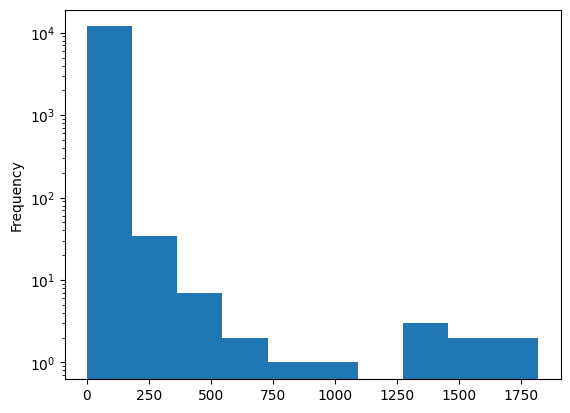

In [20]:
# anime['episodes'].sort_values(ascending=False).head(25)
anime[anime['episodes'] > 0]['episodes'].plot(kind='hist', logy=True)

In [21]:
# Extract all unique genres from anime
all_genres = anime['genre'].dropna().str.split(',')
unique_genres = set([genre.strip() for genres in all_genres for genre in genres])

print("Number of unique genres:", len(unique_genres))
print("\nUnique genres:")
print(sorted(unique_genres))


Number of unique genres: 44

Unique genres:
['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Unknown', 'Vampire', 'Yaoi', 'Yuri']


In [22]:
# Create a genre dataframe
genres = pd.DataFrame(index=anime.index)

# Iterate through unique genres and create binary columns
for genre in sorted(unique_genres):
    genres[genre] = anime['genre'].str.contains(genre).astype(int)

# Display the first few rows and shape of the genre dataframe
print("Genre DataFrame shape:", genres.shape)
print("\nFirst few rows of the Genre DataFrame:")
print(genres.head())

# Verify the sum of genres for each anime
print("\nSum of genres for each anime:")
print(genres.sum(axis=1).value_counts().sort_index())



Genre DataFrame shape: (12294, 44)

First few rows of the Genre DataFrame:
   Action  Adventure  Cars  Comedy  Dementia  Demons  Drama  Ecchi  Fantasy  \
0       0          0     0       0         0       0      1      0        0   
1       1          1     0       0         0       0      1      0        1   
2       1          0     0       1         0       0      0      0        0   
3       0          0     0       0         0       0      0      0        0   
4       1          0     0       1         0       0      0      0        0   

   Game  ...  Slice of Life  Space  Sports  Super Power  Supernatural  \
0     0  ...              0      0       0            0             1   
1     0  ...              0      0       0            0             0   
2     0  ...              0      0       0            0             0   
3     0  ...              0      0       0            0             0   
4     0  ...              0      0       0            0             0   

   Thriller

In [23]:
# Check for duplicates in anime DataFrame
print("Duplicate rows in anime DataFrame:")
print(anime.duplicated().sum())
print("\nDuplicate anime_id in anime DataFrame:")
print(anime['anime_id'].duplicated().sum())

# Check for duplicates in ratings DataFrame
print("\nDuplicate rows in ratings DataFrame:")
print(ratings.duplicated().sum())
print("\nDuplicate (user_id, anime_id) pairs in ratings DataFrame:")
print(ratings.duplicated(subset=['user_id', 'anime_id']).sum())


Duplicate rows in anime DataFrame:
0

Duplicate anime_id in anime DataFrame:
0

Duplicate rows in ratings DataFrame:
1

Duplicate (user_id, anime_id) pairs in ratings DataFrame:
7


In [24]:
ratings = ratings.drop_duplicates(subset=['user_id', 'anime_id'], keep='last')
ratings['total_watch'] = ratings['user_id'].map(ratings['user_id'].value_counts())

In [30]:
# Separate ratings into rated and unrated
rated = ratings[ratings['rating'] >= 0]
# unrated = ratings[ratings['rating'] < 0]

# Count the occurrences of each user_id
user_counts = rated['user_id'].value_counts()
top_user_ratings = rated.groupby('user_id')['rating'].quantile(0.75)
bottom_user_ratings = rated.groupby('user_id')['rating'].quantile(0.25)

# Create a mask for users with more than 20 ratings
frequent_users = user_counts[user_counts > 20].index
# Create a mask for rows with rating > user_ratings
high_rating_mask = rated['rating'] > rated['user_id'].map(user_ratings)

# Display information about the high rating mask
print("\nNumber of high ratings:", high_rating_mask.sum())
print("Percentage of high ratings: {:.2f}%".format(high_rating_mask.mean() * 100))


# Create a subset of rated df with users who have more than 10 ratings
rated_subset = rated[rated['user_id'].isin(frequent_users)]

# Display information about the new subset
print("Original rated DataFrame shape:", rated.shape)
print("Subset of rated DataFrame shape:", rated_subset.shape)
print("\nNumber of unique users in original:", rated['user_id'].nunique())
print("Number of unique users in subset:", rated_subset['user_id'].nunique())


Original rated DataFrame shape: (6337234, 4)
Subset of rated DataFrame shape: (6151960, 4)

Number of unique users in original: 69600
Number of unique users in subset: 46502


In [37]:
import pandas as pd
teste = pd.DataFrame(rated[rated['user_id'] < 30].sample(50))

# user_counts = teste['user_id'].value_counts()
# print(user_counts)
# teste[teste['user_id'] == 5]
# teste.groupby('user_id')['rating'].quantile(0.75)
user_ratings = teste.groupby('user_id')['rating'].quantile(0.25)
user_ratings2 = teste.groupby('user_id')['rating'].quantile(0.75)
mask1 = teste['rating'] < teste['user_id'].map(user_ratings)
mask2 = teste['rating'] > teste['user_id'].map(user_ratings2)
print(teste[mask1 | mask2])
print(teste)

      user_id  anime_id  rating  total_watch
1668       17      1889      10          601
2758       27     11319      10           80
761         5     29803       8          467
2105       17     25519       8          601
1576       14     16782       8          123
1957       17     19365       5          601
921         7     10110       6          343
1796       17     10396       5          601
1064        7     24227       6          343
725         5     23273       8          467
1120        7     31043       9          343
2904       29     11209       3          129
1571       14     16067       7          123
1821       17     11577       9          601
      user_id  anime_id  rating  total_watch
2919       29     16498       8          129
497         5      7817       2          467
2584       24     10067       8           66
1220       11       790       8          112
1668       17      1889      10          601
2758       27     11319      10           80
761       

In [12]:
# Get 20% of the rated_subset as test set
_, rating_test = train_test_split(rated_subset, test_size=0.2, random_state=42)

# Create the train set by removing the test set from the whole ratings DataFrame
rating_train = ratings[~ratings.index.isin(rating_test.index)]

In [62]:
# Test if all rating_test user_ids are also shown in rating_train
test_users = set(rating_test['user_id'])
train_users = set(rating_train['user_id'])

all_test_users_in_train = test_users.issubset(train_users)

print(f"All test users are present in the training set: {all_test_users_in_train}")

if not all_test_users_in_train:
    missing_users = test_users - train_users
    print(f"Number of test users not in training set: {len(missing_users)}")
    print(f"Sample of missing users: {list(missing_users)[:5]}")


All test users are present in the training set: True


In [63]:
# Ensure that for every user_id in test_users, there are examples of bottom quartile and top quartile ratings

# Function to get bottom and top quartile ratings for a user
def get_quartile_ratings(user_id, ratings_df):
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]['rating']
    bottom_quartile = user_ratings.quantile(0.25)
    top_quartile = user_ratings.quantile(0.75)
    return user_ratings[user_ratings <= bottom_quartile], user_ratings[user_ratings >= top_quartile]

# Initialize lists to store users that need adjustment
users_to_adjust = []

# Check each user in test_users
for user_id in test_users:
    bottom_q, top_q = get_quartile_ratings(user_id, ratings)
    
    # Check if both quartiles are represented in rating_test
    if not (any(rating_test[(rating_test['user_id'] == user_id) & (rating_test['rating'] <= bottom_q.max())]) and
            any(rating_test[(rating_test['user_id'] == user_id) & (rating_test['rating'] >= top_q.min())])):
        users_to_adjust.append(user_id)

print(f"Number of users needing adjustment: {len(users_to_adjust)}")

# Adjust the test set for users lacking quartile representation
for user_id in users_to_adjust:
    bottom_q, top_q = get_quartile_ratings(user_id, ratings)
    
    # Add a bottom quartile rating to test set if missing
    if not any(rating_test[(rating_test['user_id'] == user_id) & (rating_test['rating'] <= bottom_q.max())]):
        bottom_sample = ratings[(ratings['user_id'] == user_id) & (ratings['rating'] <= bottom_q.max())].sample(1)
        rating_test = pd.concat([rating_test, bottom_sample])
        rating_train = rating_train[~rating_train.index.isin(bottom_sample.index)]
    
    # Add a top quartile rating to test set if missing
    if not any(rating_test[(rating_test['user_id'] == user_id) & (rating_test['rating'] >= top_q.min())]):
        top_sample = ratings[(ratings['user_id'] == user_id) & (ratings['rating'] >= top_q.min())].sample(1)
        rating_test = pd.concat([rating_test, top_sample])
        rating_train = rating_train[~rating_train.index.isin(top_sample.index)]

print("Adjustment complete.")
print(f"New test set shape: {rating_test.shape}")
print(f"New train set shape: {rating_train.shape}")

# Verify the adjustment
users_lacking_quartiles = sum(1 for user_id in test_users if not (
    any(rating_test[(rating_test['user_id'] == user_id) & (rating_test['rating'] <= get_quartile_ratings(user_id, ratings)[0].max())]) and
    any(rating_test[(rating_test['user_id'] == user_id) & (rating_test['rating'] >= get_quartile_ratings(user_id, ratings)[1].min())])
))

print(f"Users still lacking quartile representation: {users_lacking_quartiles}")


Number of users needing adjustment: 0
Adjustment complete.
New test set shape: (1253843, 4)
New train set shape: (6559887, 4)
Users still lacking quartile representation: 0


In [42]:
import pickle
redo = False

user_item_matrix = rated.pivot(index='user_id', columns='anime_id', values='rating')

if redo:
    from sklearn.decomposition import NMF
    # There are 44 genres, 20 components seems a good place to start
    dec = NMF(n_components=20, random_state=42)
    w1 = dec.fit_transform(user_item_matrix.fillna(0)) # user-group matrix
    h1 = dec.components_ # group-anime matrix

    # Save w1 and h1 to a pickle file
    with open('data/nmf_components.pkl', 'wb') as f:
        pickle.dump({'w1': w1, 'h1': h1}, f)

    print("NMF components (w1 and h1) have been saved to 'nmf_components.pkl'")

else:
    # Load the NMF components from the pickle file
    with open('data/nmf_components.pkl', 'rb') as f:
        nmf_components = pickle.load(f)
    w1 = nmf_components['w1']
    h1 = nmf_components['h1']

    print("NMF components (w1 and h1) have been loaded from 'nmf_components.pkl'")

NMF components (w1 and h1) have been loaded from 'nmf_components.pkl'


In [69]:
groups = w1.argmax(axis=1)
print(len(groups))

print('-',len(user_item_matrix), '-')
print(max(user_item_matrix.index))
teste = user_item_matrix.reset_index()

a = teste[teste['user_id'] == 73516].index 
groups[a] == groups[69600-1]
user_group = groups[a]

groups[groups == user_group].index

69600
- 69600 -
73516


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [99]:
# np.where(groups == 19)[0]
print(len(user_item_matrix.columns), max(user_item_matrix.columns))
h1.shape
h1[:,9926]

animes_group = h1.argmax(axis=1)
[(row, col) for row, col in enumerate(animes_group)]
h1

9927 34475


array([[0.00000000e+00, 0.00000000e+00, 4.97000206e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.77700107e+01, 1.09564403e+01, 1.32863280e+01, ...,
        2.36247912e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.43008610e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 1.50334867e-01, 0.00000000e+00, ...,
        5.15256983e-04, 0.00000000e+00, 1.05931941e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 5.19137383e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [93]:
import numpy as np
import random

# Set a seed for reproducibility
np.random.seed(0)

# Create a 3x3 matrix with random integers between 0 and 100
matrix = np.random.randint(0, 100, size=(3, 3))

# Generate random integers greater than 10 for row and column names
row_names = [random.randint(11, 20) for _ in range(3)]
col_names = [random.randint(21, 30) for _ in range(3)]

# Print the matrix and names
print("Matrix:")
print(matrix)
print("Row names:", row_names)
print("Column names:", col_names)

# Find the indices of the maximum values along each row
max_indices = np.argmax(matrix, axis=1)

# Retrieve the corresponding row and column names
for i, row_index in enumerate(max_indices):
    print(f"Row name: {row_names[i]}, Column name: {col_names[row_index]}, Max value: {matrix[i, row_index]}")


Matrix:
[[44 47 64]
 [67 67  9]
 [83 21 36]]
Row names: [18, 19, 18]
Column names: [30, 25, 21]
Row name: 18, Column name: 21, Max value: 64
Row name: 19, Column name: 30, Max value: 67
Row name: 18, Column name: 30, Max value: 83


Number of users in each group:
0     1175
1     4185
2     3862
3     3372
4     6620
5     2096
6     1508
7     2137
8     2293
9     4247
10    4413
11    1402
12    8727
13    1017
14    2871
15    6453
16    3641
17    2090
18    2541
19    4950
Name: count, dtype: int64

Total number of users: 69600

Percentage of users in each group:
0      1.69
1      6.01
2      5.55
3      4.84
4      9.51
5      3.01
6      2.17
7      3.07
8      3.29
9      6.10
10     6.34
11     2.01
12    12.54
13     1.46
14     4.12
15     9.27
16     5.23
17     3.00
18     3.65
19     7.11
Name: count, dtype: float64


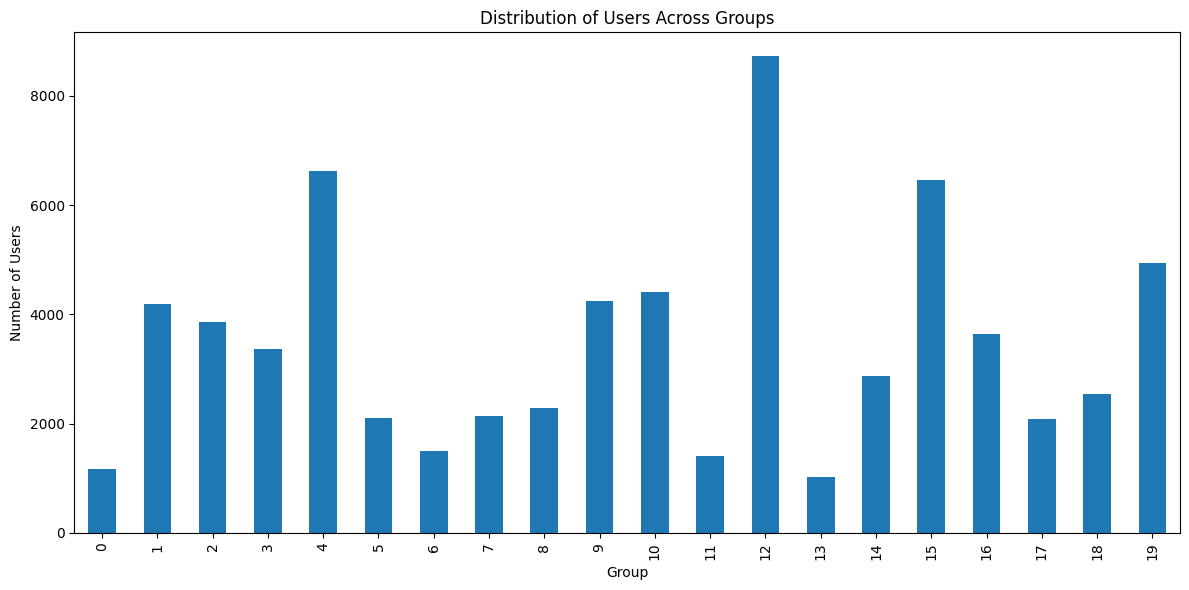

In [15]:

# Get the group with the highest number for each user
user_groups = w1.argmax(axis=1)

# Count the number of users in each group
group_counts = pd.Series(user_groups).value_counts().sort_index()

# Display the results
print("Number of users in each group:")
print(group_counts)

# Calculate and display the total number of users
total_users = group_counts.sum()
print(f"\nTotal number of users: {total_users}")

# Calculate and display the percentage of users in each group
group_percentages = (group_counts / total_users * 100).round(2)
print("\nPercentage of users in each group:")
print(group_percentages)

# Visualize the distribution
plt.figure(figsize=(12, 6))
group_counts.plot(kind='bar')
plt.title('Distribution of Users Across Groups')
plt.xlabel('Group')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()


In [70]:
print(group_percentages.describe())
lower_bound = group_percentages.mean() - 2 * group_percentages.std()
upper_bound = group_percentages.mean() + 2 * group_percentages.std()
within_2std = group_percentages[(group_percentages >= lower_bound) & (group_percentages <= upper_bound)]
percentage_within_2std = (len(within_2std) / len(group_percentages)) * 100

print(f"Mean: {group_percentages.mean():.2f}")
print(f"Standard deviation: {group_percentages.std():.2f}")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")
print(f"Percentage of distribution within 2 standard deviations of the mean: {percentage_within_2std:.2f}%")

count    20.000000
mean      4.998500
std       2.919319
min       1.460000
25%       3.007500
50%       4.480000
75%       6.160000
max      12.540000
Name: count, dtype: float64
Mean: 5.00
Standard deviation: 2.92
Lower bound: -0.84
Upper bound: 10.84
Percentage of distribution within 2 standard deviations of the mean: 95.00%


In [16]:
def top_users(w1, user, n=10):
    """
    Get the top n similar users for a given user
    """
    user_groups = pd.DataFrame({'group':w1.argmax(axis=1), 'weight':w1.max(axis=1)})
    user_group = user_groups.iloc[user] # get the group of the user
    similar_users = user_groups[user_groups['group'] == user_group['group']] # get all users in the same group
    similar_users = similar_users[similar_users.index != user] # remove the user itself
    similar_users = similar_users.sort_values(by='weight', ascending=False) # sort by weight
    return similar_users.head(n).index
    

In [17]:
top_users(w1, 42, 10)

Index([677, 22009, 34995, 1366, 18222, 20708, 36790, 29792, 13223, 22917], dtype='int64')

In [40]:
def get_top_animes_for_user(user_id, w1, ratings, n_users=10, n_animes=10):
    # Get top n similar users
    similar_users = top_users(w1, user_id, n=n_users)
    
    # Get animes watched by these users
    similar_users_ratings = ratings[ratings['user_id'].isin(similar_users)]
    
    # Get animes watched by the target user
    target_user_animes = ratings[ratings['user_id'] == user_id]
    watched_animes = set(target_user_animes['anime_id'])
    
    # Filter out animes that the target user has already watched
    unwatched_animes = similar_users_ratings[~similar_users_ratings['anime_id'].isin(watched_animes)]
    
    # Rank the remaining animes based on their average rating
    top_animes = unwatched_animes.groupby('anime_id')['rating'].mean().sort_values(ascending=False).head(n_animes)
    
    return top_animes

# Example usage
random_user_id = rating_test['user_id'].sample(n=1).iloc[0]
user_id = random_user_id
top_animes = get_top_animes_for_user(user_id, w1, ratings, n_users=10, n_animes=50)
print("Top 10 recommended animes for user", user_id)
# Get the anime names for the top recommended animes
top_anime_names = anime[anime['anime_id'].isin(top_animes.index)][['anime_id', 'name']]
top_anime_names = top_anime_names.set_index('anime_id')

# Merge the anime names with the top animes ratings
top_animes_with_names = top_animes.to_frame().join(top_anime_names)

# Print the top animes with their names and average ratings
print(top_animes_with_names[['name', 'rating']].to_string())

Top 10 recommended animes for user 11137
                                                                     name  rating
anime_id                                                                         
26                                                             Texhnolyze    10.0
6377                                         Zan Sayonara Zetsubou Sensei    10.0
376                                                    Elfen Lied Special    10.0
14349                                               Little Witch Academia    10.0
14267                         Persona 4 the Animation: The Factor of Hope    10.0
4565                         Tengen Toppa Gurren Lagann Movie: Lagann-hen    10.0
2246                                                             Mononoke    10.0
4181                                                 Clannad: After Story    10.0
1117                          Pokemon: Maboroshi no Pokemon Lugia Bakutan    10.0
12711                                 Uta no☆Prince-sama♪

In [42]:
# Choose 1 user_id randomly from rating_test
rating_test[rating_test['user_id'] == user_id & rating_test['anime_id'].isin(top_animes.index)]

,user_id,anime_id,rating,total_watch


### Feature engineering
- How popular the user likes their anime?
- How many times the user has watched the anime genre?
- How well the user rated a genre?
- How to consider what's the base rate of liking an anime?

### Evaluation
- Instead of asking for a suggestion, get a validation example and see how well it would perform.

In [43]:
# Calculate average members and average rating for each user
user_stats = ratings.merge(anime[['anime_id', 'members']], on='anime_id', how='left')
user_stats = user_stats.groupby('user_id').mean()['members'].reset_index()

# Merge the calculated averages back to the ratings dataframe
ratings = ratings.merge(user_stats, on='user_id', how='left')

# Display the first few rows of the updated ratings dataframe
print(ratings.head())


   user_id  anime_id  rating  total_watch        members
0        1        20      -1          153  198889.784314
1        1        24      -1          153  198889.784314
2        1        79      -1          153  198889.784314
3        1       226      -1          153  198889.784314
4        1       241      -1          153  198889.784314


<Axes: >

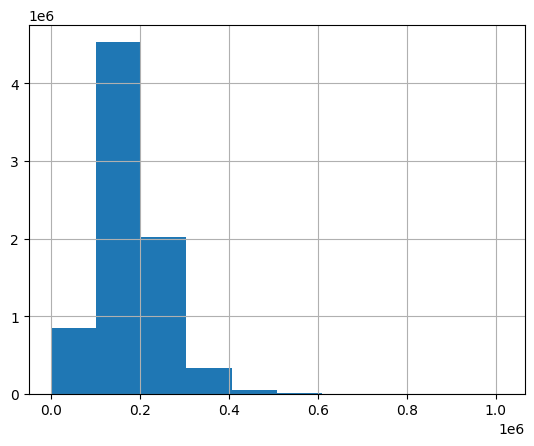

In [47]:
ratings.rename(columns={'members': 'average_members'}, inplace=True)
ratings['average_members'].hist()


In [48]:
# Calculate the 25th and 75th percentiles of average_members
percentile_25 = ratings['average_members'].quantile(0.25)
percentile_75 = ratings['average_members'].quantile(0.75)

# Create a new column 'user_type' based on the percentiles
ratings['user_type'] = pd.cut(ratings['average_members'], 
                              bins=[-float('inf'), percentile_25, percentile_75, float('inf')],
                              labels=['hipster', 'mid', 'trendy'])

# Display the first few rows to verify the new column
print(ratings[['user_id', 'average_members', 'user_type']].head(10))

# Display the distribution of user types
print(ratings['user_type'].value_counts(normalize=True))


   user_id  average_members user_type
0        1    198889.784314       mid
1        1    198889.784314       mid
2        1    198889.784314       mid
3        1    198889.784314       mid
4        1    198889.784314       mid
5        1    198889.784314       mid
6        1    198889.784314       mid
7        1    198889.784314       mid
8        1    198889.784314       mid
9        1    198889.784314       mid
user_type
mid        0.500020
hipster    0.250013
trendy     0.249967
Name: proportion, dtype: float64


In [58]:
# Merge ratings with anime to get genre information
user_genre_data = ratings.merge(anime[['anime_id', 'genre']], on='anime_id', how='left')

# Split the genre string into a list
user_genre_data['genre'] = user_genre_data['genre'].fillna('Unknown').str.split(',')

# Explode the genre list so each genre gets its own row
user_genre_data = user_genre_data.explode('genre')

# Remove leading/trailing whitespace from genre names
user_genre_data['genre'] = user_genre_data['genre'].str.strip()

# Create a pivot table to count genre occurrences for each user
genre_counts = pd.pivot_table(user_genre_data, values='rating', index='user_id', 
                              columns='genre', aggfunc='count', fill_value=0)

# Normalize the counts for each user
genre_counts_normalized = genre_counts.div(genre_counts.sum(axis=1), axis=0)

# Reset the index to make user_id a column
genre_counts_normalized = genre_counts_normalized.reset_index()

# Display the first few rows of the normalized genre counts
print(genre_counts_normalized.head())

# Display the shape of the resulting dataframe
print(f"\nShape of the genre counts table: {genre_counts_normalized.shape}")


genre  user_id    Action  Adventure      Cars    Comedy  Dementia    Demons  \
0            1  0.093284   0.018657  0.000000  0.120647  0.000000  0.017413   
1            2  0.000000   0.000000  0.000000  0.222222  0.000000  0.000000   
2            3  0.139434   0.104575  0.000000  0.084967  0.000000  0.008715   
3            4  0.129707   0.054393  0.000000  0.112971  0.000000  0.008368   
4            5  0.076288   0.045190  0.001944  0.158406  0.000486  0.009718   

genre     Drama     Ecchi   Fantasy  ...  Slice of Life     Space    Sports  \
0      0.036070  0.080846  0.057214  ...       0.008706  0.000000  0.001244   
1      0.000000  0.000000  0.000000  ...       0.222222  0.000000  0.111111   
2      0.067538  0.010893  0.113290  ...       0.010893  0.000000  0.021786   
3      0.020921  0.025105  0.104603  ...       0.025105  0.000000  0.008368   
4      0.037901  0.048591  0.046647  ...       0.035957  0.001944  0.019436   

genre  Super Power  Supernatural  Thriller  Unknow

In [53]:
genre_counts_normalized.tail()

genre,user_id,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi,Yuri
73510,73512,0.071429,0.028571,0.0,0.085714,0.014286,0.014286,0.128571,0.000000,0.057143,...,0.042857,0.000000,0.000000,0.000000,0.100000,0.000000,0.0,0.000000,0.0,0.000000
73511,73513,0.078947,0.059211,0.0,0.118421,0.006579,0.000000,0.105263,0.032895,0.065789,...,0.026316,0.026316,0.006579,0.000000,0.039474,0.006579,0.0,0.006579,0.0,0.000000
73512,73514,0.000000,0.166667,0.0,0.166667,0.000000,0.000000,0.166667,0.000000,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
73513,73515,0.144896,0.058178,0.0,0.065862,0.001098,0.017563,0.049396,0.007684,0.066959,...,0.007684,0.007684,0.003293,0.041712,0.079034,0.018661,0.0,0.012075,0.0,0.001098
73514,73516,0.142857,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.0,0.000000,0.0,0.000000


In [54]:
# Check for duplicate user IDs in genre_counts_normalized
duplicate_users = genre_counts_normalized['user_id'].duplicated().sum()

print(f"Number of duplicate user IDs: {duplicate_users}")

if duplicate_users == 0:
    print("There are no duplicate user IDs in genre_counts_normalized.")
else:
    print("There are duplicate user IDs in genre_counts_normalized.")
    print("\nFirst few rows with duplicate user IDs:")
    print(genre_counts_normalized[genre_counts_normalized['user_id'].duplicated(keep=False)].sort_values('user_id').head())

# Check if the index is missing any numbers
min_user_id = genre_counts_normalized['user_id'].min()
max_user_id = genre_counts_normalized['user_id'].max()
expected_range = set(range(min_user_id, max_user_id + 1))
actual_user_ids = set(genre_counts_normalized['user_id'])

missing_ids = expected_range - actual_user_ids

if len(missing_ids) > 0:
    print(f"\nThe index is missing {len(missing_ids)} numbers.")
    print(f"First few missing numbers: {sorted(list(missing_ids))[:5]}")
else:
    print("\nThe index is not missing any numbers.")

print(f"\nTotal number of rows: {len(genre_counts_normalized)}")
print(f"Number of unique user IDs: {genre_counts_normalized['user_id'].nunique()}")
print(f"Minimum user ID: {min_user_id}")
print(f"Maximum user ID: {max_user_id}")



Number of duplicate user IDs: 0
There are no duplicate user IDs in genre_counts_normalized.

The index is missing 1 numbers.
First few missing numbers: [46809]

Total number of rows: 73515
Number of unique user IDs: 73515
Minimum user ID: 1
Maximum user ID: 73516


In [60]:
# genre_counts_normalized = genre_counts_normalized.reset_index(drop=True)
genre_counts_normalized.describe()

genre,user_id,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi,Yuri
count,73515.000000,73515.000000,73515.000000,73515.000000,73515.000000,73515.000000,73515.000000,73515.000000,73515.000000,73515.000000,...,73515.000000,73515.000000,73515.000000,73515.000000,73515.000000,73515.000000,73515.000000,73515.000000,73515.000000,73515.000000
mean,36758.363286,0.095044,0.051017,0.000461,0.106547,0.002376,0.010501,0.064284,0.021307,0.058439,...,0.029680,0.004209,0.006433,0.024489,0.059601,0.013054,0.000001,0.007039,0.001133,0.000164
std,21222.497501,0.041535,0.036348,0.003015,0.042583,0.007325,0.014598,0.034697,0.024441,0.032864,...,0.030720,0.010330,0.014500,0.025111,0.033316,0.020818,0.000094,0.012306,0.008733,0.002060
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18379.500000,0.071429,0.028409,0.000000,0.084175,0.000000,0.000000,0.044496,0.000000,0.041176,...,0.008772,0.000000,0.000000,0.011385,0.042424,0.002096,0.000000,0.000000,0.000000,0.000000
50%,36758.000000,0.093878,0.045597,0.000000,0.107353,0.000000,0.007812,0.061538,0.014493,0.056090,...,0.024490,0.000000,0.001594,0.020571,0.057522,0.008584,0.000000,0.004673,0.000000,0.000000
75%,55137.500000,0.117720,0.067721,0.000000,0.129199,0.002354,0.013889,0.081081,0.032164,0.072807,...,0.041667,0.004808,0.007812,0.030973,0.073118,0.016575,0.000000,0.009174,0.000000,0.000000
max,73516.000000,0.500000,0.500000,0.200000,1.000000,0.250000,0.333333,0.500000,0.333333,0.500000,...,0.500000,0.500000,0.333333,0.333333,0.500000,0.500000,0.022472,0.333333,0.500000,0.333333


In [61]:
# Merge ratings with anime to get genre information
user_genre_data = ratings.merge(anime[['anime_id', 'genre']], on='anime_id', how='left')

# Split the genre string into a list
user_genre_data['genre'] = user_genre_data['genre'].fillna('Unknown').str.split(',')

# Remove rows with negative ratings
positive_ratings = user_genre_data[user_genre_data['rating'] > 0]

# Explode the genre list so each genre gets its own row
positive_ratings = positive_ratings.explode('genre')

# Remove leading/trailing whitespace from genre names
positive_ratings['genre'] = positive_ratings['genre'].str.strip()

# Create a pivot table to count genre occurrences for each user
genre_ratings = pd.pivot_table(positive_ratings, values='rating', index='user_id', 
                              columns='genre', aggfunc='mean', fill_value=0)

# Reset the index to make user_id a column
genre_ratings = genre_ratings.reset_index()

# Display the first few rows of the normalized genre counts
print(genre_ratings.head())



genre  user_id     Action  Adventure  Cars     Comedy  Dementia     Demons  \
0            1  10.000000  10.000000   0.0  10.000000  0.000000  10.000000   
1            2   0.000000   0.000000   0.0  10.000000  0.000000   0.000000   
2            3   7.290323   7.531915   0.0   7.657895  0.000000   6.500000   
3            5   4.701299   5.186813   6.0   4.155763  1.000000   4.157895   
4            7   7.484127   7.700000   0.0   7.297980  9.333333   7.250000   

genre     Drama      Ecchi    Fantasy  ...  Slice of Life  Space     Sports  \
0      0.000000  10.000000  10.000000  ...       0.000000   0.00   0.000000   
1      0.000000   0.000000   0.000000  ...       0.000000   0.00  10.000000   
2      7.451613   7.800000   7.576923  ...       7.800000   0.00   8.600000   
3      5.217949   2.510000   4.410526  ...       4.506849   7.25   6.000000   
4      7.750000   6.909091   7.337209  ...       7.137255   0.00   7.333333   

genre  Super Power  Supernatural  Thriller  Unknown   Va

In [72]:
ratings[ratings['rating'] > 0][['user_id', 'rating']].groupby('user_id').mean().reset_index()


,user_id,rating
0,1,10.000000
1,2,10.000000
2,3,7.565217
3,5,4.355120
4,7,7.387755
...,...,...
69595,73512,8.583333
69596,73513,7.515152
69597,73514,10.000000
69598,73515,8.547486


In [98]:
# Create a test DataFrame with random user_ids and random episode numbers
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Generate random user_ids (assuming user_ids range from 1 to 73516 based on previous context)
n_samples = 10
user_ids = np.random.randint(1, 73517, n_samples)

# Generate random episode numbers (assuming episodes range from 1 to 1818 based on previous context)
# episodes = np.random.randint(1, 1819, n_samples)
episodes = [-1, 1, 35, 34, 36, 500, 499, 501, 10000000, 100000000]

# Create the test DataFrame
test_df = pd.DataFrame({
    'user_id': user_ids,
    'episodes': episodes
})

# Display the first few rows and basic information about the test DataFrame
# print(test_df.head())
# print("\nDataFrame Info:")
# print(test_df.info())
# print("\nDataFrame Description:")
# print(test_df.describe())
test_df['episodes_t'] = pd.cut(test_df['episodes'], bins=[-np.inf, 0, 1, 35, 500, np.inf], labels=['Unknown', 'Movie', 'Short', 'Some_Seasons', 'Huge'])
test_df.head()


,user_id,episodes,episodes_t
0,15796,-1,Unknown
1,861,1,Movie
2,54887,35,Short
3,6266,34,Short
4,37195,36,Some_Seasons


In [101]:
import pandas as pd
import json

# Load the anime and rating CSV files
anime_df = pd.read_csv('data/anime.csv')
rating_df = pd.read_csv('data/rating.csv')

# Convert each DataFrame to a JSON object
anime_json = anime_df.to_json(orient='records')
rating_json = rating_df.to_json(orient='records')

# Parse the JSON objects into Python dictionaries
anime_dict = json.loads(anime_json)
rating_dict = json.loads(rating_json)

# Unify both dictionaries in a bigger dictionary
unified_dict = {
    'anime': anime_dict,
    'rating': rating_dict
}

# Convert the unified dictionary to a JSON file
with open('unified_data.json', 'w') as f:
    json.dump(unified_dict, f, indent=4)